In [48]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h1>이미지파일 불러오기</h1>

In [49]:
# 데이터가 저장된 최상위 폴더 경로
base_dir = r"C:\Users\oos04\OneDrive\바탕 화면\Final_Project\oos\Data\Skin_Phone\Train\Smart_Phone_Image"

In [ ]:
# 결과를 저장할 딕셔너리
image_data = {}  # {폴더명: {이미지파일명: OpenCV 이미지 객체}}

# 폴더 순회
for idx, folder_name in enumerate(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)

    # 폴더인지 확인
    if os.path.isdir(folder_path):
        if idx % 100 == 0:
            print(f"Processing folder: {idx}")

        # 폴더별 이미지 저장
        folder_images = {}

        # 폴더 내 파일 탐색
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # 이미지 파일 처리 (.jpg 확장자)
            if file_name.endswith("F.jpg"):
                try:
                    # 한글 경로 처리: 바이너리 읽기 후 OpenCV로 디코딩
                    with open(file_path, 'rb') as f:
                        file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)

                    # 이미지 로드 및 저장
                    if image is not None:
                        image_data[file_name] = image
                    else:
                        print(f"Failed to load image: {file_path}")
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")

        # 폴더의 이미지 데이터를 최종 딕셔너리에 추가
        #image_data[folder_name] = folder_images 

print("Image loading complete!")

Processing folder: 0002
Processing folder: 0128
Processing folder: 0258
Processing folder: 0384
Processing folder: 0520
Processing folder: 0644
Processing folder: 0768
Processing folder: 0891
Processing folder: 1017
Image loading complete!


<h1>메타데이터 불러오기</h1>

In [54]:
#경로지정
base_dir = r"C:\Users\oos04\OneDrive\바탕 화면\Final_Project\oos\Data\Skin_Phone\Train\Smart_Phone_Label"

In [ ]:
#제이슨파일 저장할 딕셔너리 생성
json_data = {}

# 지정한 경로에 있는 파일들을 가져옴
for idx, forder_name in enumerate(os.listdir(base_dir)):
    #기본경로에 위에가져온 파일이름을 붙여서 새로운 경로 작성
    forder_path = os.path.join(base_dir, forder_name)
    #폴더인지 확인하는 과정
    if os.path.isdir(forder_path):
        if idx % 100 == 0:
            print(f"processing folder : {idx}")


        #폴더를 순회하며 파일 검색
        for file_name in os.listdir(forder_path):

            #파일 경로 합치기
            file_path = os.path.join(forder_path, file_name)

            #01.json으로 끝나는 파일 찾기
            if file_name.endswith("F_01.json"):
                try:
                    with open(file_path, "r", encoding= "utf-8") as f:
                        one_json_data = json.load(f)
                    file_name_no_ext = os.path.splitext(file_name)[0]
                    json_data[file_name_no_ext] = one_json_data
                except Exception as e:
                    print(f"Error {file_path} : {e}")

processing folder : 0002
processing folder : 0128
processing folder : 0258
processing folder : 0384
processing folder : 0520
processing folder : 0644
processing folder : 0768
processing folder : 0891
processing folder : 1017


<h1>bbox 이용해서 이미지파일 자르기</h1>

In [91]:
cropped_image_dict = {} # 저장받을 딕셔너리 생성

for idx, id in enumerate(json_data.keys()): # 파일이름 조회 : '0002_03_F_01' ....
    if idx % 100 == 0:
        print(f"compelete : {idx}")
    bbox = json_data[id]['images']['bbox'] #조회된 파일의 비박스정보 가져오기
    x1, y1, x2, y2 = bbox #비박스 데이터 나누기
    image_file_name = json_data[id]['info']['filename'] #해당 제이슨 파일의 이미지파일 정보조회
    file_name = os.path.splitext(image_file_name)[0]
    image = image_data[image_file_name] #이미지 불러오기
    cropped_image = image[y1:y2, x1:x2] #불러온 이미지 위에 저장한 비박스로 자르기
    cropped_image_dict[file_name+"_01"] = cropped_image #자른이미지 딕셔너리에 이름과 3차원데이터로 저장하기

compelete : 0
compelete : 100
compelete : 200
compelete : 300
compelete : 400
compelete : 500
compelete : 600
compelete : 700
compelete : 800


In [93]:
# 이미지 및 바운딩 박스 정보 딕셔너리 구성 확인
print(cropped_image_dict.keys())
print(len(cropped_image_dict.keys()))
print(cropped_image_dict['0002_03_F_01'].shape)

dict_keys(['0002_03_F_01', '0003_03_F_01', '0006_03_F_01', '0007_03_F_01', '0008_03_F_01', '0009_03_F_01', '0010_03_F_01', '0011_03_F_01', '0012_03_F_01', '0014_03_F_01', '0016_03_F_01', '0017_03_F_01', '0018_03_F_01', '0019_03_F_01', '0020_03_F_01', '0022_03_F_01', '0023_03_F_01', '0024_03_F_01', '0025_03_F_01', '0026_03_F_01', '0027_03_F_01', '0028_03_F_01', '0029_03_F_01', '0030_03_F_01', '0031_03_F_01', '0032_03_F_01', '0033_03_F_01', '0035_03_F_01', '0036_03_F_01', '0037_03_F_01', '0038_03_F_01', '0039_03_F_01', '0040_03_F_01', '0041_03_F_01', '0042_03_F_01', '0043_03_F_01', '0044_03_F_01', '0045_03_F_01', '0046_03_F_01', '0047_03_F_01', '0048_03_F_01', '0049_03_F_01', '0051_03_F_01', '0052_03_F_01', '0054_03_F_01', '0055_03_F_01', '0057_03_F_01', '0058_03_F_01', '0060_03_F_01', '0062_03_F_01', '0064_03_F_01', '0065_03_F_01', '0066_03_F_01', '0068_03_F_01', '0070_03_F_01', '0071_03_F_01', '0073_03_F_01', '0074_03_F_01', '0076_03_F_01', '0077_03_F_01', '0078_03_F_01', '0079_03_F_01

In [ ]:
# 제이슨파일 딕셔너리 구성 확인
print(json_data.keys())
print(len(json_data.keys()))
print(json_data['0002_03_F_01'].keys())
json_data['0002_03_F_01']

dict_keys(['0002_03_F_01', '0003_03_F_01', '0006_03_F_01', '0007_03_F_01', '0008_03_F_01', '0009_03_F_01', '0010_03_F_01', '0011_03_F_01', '0012_03_F_01', '0014_03_F_01', '0016_03_F_01', '0017_03_F_01', '0018_03_F_01', '0019_03_F_01', '0020_03_F_01', '0022_03_F_01', '0023_03_F_01', '0024_03_F_01', '0025_03_F_01', '0026_03_F_01', '0027_03_F_01', '0028_03_F_01', '0029_03_F_01', '0030_03_F_01', '0031_03_F_01', '0032_03_F_01', '0033_03_F_01', '0035_03_F_01', '0036_03_F_01', '0037_03_F_01', '0038_03_F_01', '0039_03_F_01', '0040_03_F_01', '0041_03_F_01', '0042_03_F_01', '0043_03_F_01', '0044_03_F_01', '0045_03_F_01', '0046_03_F_01', '0047_03_F_01', '0048_03_F_01', '0049_03_F_01', '0051_03_F_01', '0052_03_F_01', '0054_03_F_01', '0055_03_F_01', '0057_03_F_01', '0058_03_F_01', '0060_03_F_01', '0062_03_F_01', '0064_03_F_01', '0065_03_F_01', '0066_03_F_01', '0068_03_F_01', '0070_03_F_01', '0071_03_F_01', '0073_03_F_01', '0074_03_F_01', '0076_03_F_01', '0077_03_F_01', '0078_03_F_01', '0079_03_F_01

{'info': {'filename': '0002_03_F.jpg',
  'id': '0002',
  'gender': 'F',
  'age': 50,
  'date': '2023-07-27',
  'skin_type': 0,
  'sensitive': 0},
 'images': {'device': 2,
  'width': 1920,
  'height': 2560,
  'angle': 0,
  'facepart': 1,
  'bbox': [788, 691, 1510, 1005]},
 'annotations': {'forehead_pigmentation': 1, 'forehead_wrinkle': 1},
 'equipment': {'forehead_moisture': 75.0,
  'forehead_elasticity_R0': 0.287,
  'forehead_elasticity_R1': 0.097,
  'forehead_elasticity_R2': 0.662,
  'forehead_elasticity_R3': 0.329,
  'forehead_elasticity_R4': 0.135,
  'forehead_elasticity_R5': 0.552,
  'forehead_elasticity_R6': 0.649,
  'forehead_elasticity_R7': 0.335,
  'forehead_elasticity_R8': 0.19,
  'forehead_elasticity_R9': 0.042,
  'forehead_elasticity_Q0': 57.4,
  'forehead_elasticity_Q1': 0.579,
  'forehead_elasticity_Q2': 0.438,
  'forehead_elasticity_Q3': 0.142}}

In [95]:
print(json_data.keys())
print(cropped_image_dict.keys())

dict_keys(['0002_03_F_01', '0003_03_F_01', '0006_03_F_01', '0007_03_F_01', '0008_03_F_01', '0009_03_F_01', '0010_03_F_01', '0011_03_F_01', '0012_03_F_01', '0014_03_F_01', '0016_03_F_01', '0017_03_F_01', '0018_03_F_01', '0019_03_F_01', '0020_03_F_01', '0022_03_F_01', '0023_03_F_01', '0024_03_F_01', '0025_03_F_01', '0026_03_F_01', '0027_03_F_01', '0028_03_F_01', '0029_03_F_01', '0030_03_F_01', '0031_03_F_01', '0032_03_F_01', '0033_03_F_01', '0035_03_F_01', '0036_03_F_01', '0037_03_F_01', '0038_03_F_01', '0039_03_F_01', '0040_03_F_01', '0041_03_F_01', '0042_03_F_01', '0043_03_F_01', '0044_03_F_01', '0045_03_F_01', '0046_03_F_01', '0047_03_F_01', '0048_03_F_01', '0049_03_F_01', '0051_03_F_01', '0052_03_F_01', '0054_03_F_01', '0055_03_F_01', '0057_03_F_01', '0058_03_F_01', '0060_03_F_01', '0062_03_F_01', '0064_03_F_01', '0065_03_F_01', '0066_03_F_01', '0068_03_F_01', '0070_03_F_01', '0071_03_F_01', '0073_03_F_01', '0074_03_F_01', '0076_03_F_01', '0077_03_F_01', '0078_03_F_01', '0079_03_F_01

In [96]:
import matplotlib.pyplot as plt

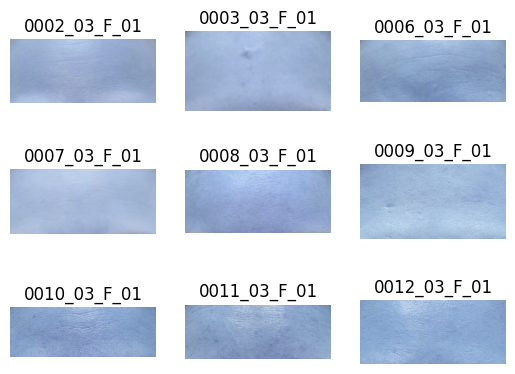

In [97]:
#잘린 이미지 파일 확인
cropped_image_file_name = cropped_image_dict.keys() # 파일명 가져오기
image_list = list(cropped_image_file_name) # 슬라이싱을 위해 리스트로 변경


for idx, cin in enumerate(image_list[:9]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(cropped_image_dict[cin])
    plt.title(cin)
    plt.axis("off")

plt.show()

<h1>데이터 병합, 저장 및 불러오기 확인</h1>

In [ ]:
# 데이터 병합
Test_Data_Set = {}
Test_Data_Set["Images"] = cropped_image_dict
Test_Data_Set["Metadata"] = json_data

In [ ]:
# 저장 후 데이터 확인
print(Test_Data_Set.keys())
print(len(Test_Data_Set['Images'].keys()))
print(len(Test_Data_Set['Metadata'].keys()))

dict_keys(['Images', 'Metadata'])
858
858


In [102]:
import pickle

In [103]:
# 파일에 데이터 저장
with open('Test_Data_Set.pkl', 'wb') as file:  # 'wb'는 바이너리 쓰기 모드
    pickle.dump(Test_Data_Set, file)

print("데이터가 'test_data_set.pkl' 파일에 저장되었습니다.")

데이터가 'test_data_set.pkl' 파일에 저장되었습니다.


In [114]:
# 저장된 파일 불러오기
with open('Data/Test_Data_Set_02.pkl', 'rb') as file:  # 'rb'는 바이너리 읽기 모드
    Test_Data = pickle.load(file)

print("파일에서 데이터를 불러왔습니다.")

파일에서 데이터를 불러왔습니다.


dict_keys(['Images', 'Metadata'])
858
858


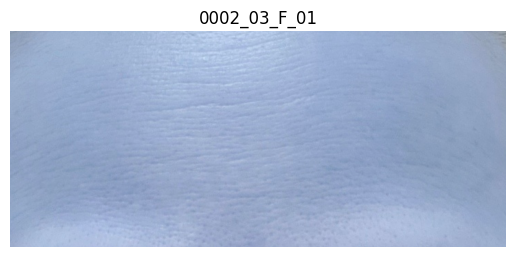

In [115]:
#불러온 데이터 확인
print(Test_Data.keys())
print(len(Test_Data['Images'].keys()))
print(len(Test_Data['Metadata'].keys()))

plt.imshow(Test_Data['Images']['0002_03_F_01'])
plt.axis("off")
plt.title(list(Test_Data['Images'].keys())[0])
plt.show()